In [ ]:
!pip install foolbox

In [ ]:
import pandas as pd
import numpy as np
import pickle
import random
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt

# Set seed.
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading the DataSets.
train_df = pd.read_csv('train_dataset/metadata.csv')
test_df = pd.read_csv('test_dataset/metadata.csv')
val_df = pd.read_csv('validation_dataset/metadata.csv')

In [ ]:
# Print the number of samples for each class.
print(train_df['diagnosis'].value_counts())

diagnosis
nevus                         1205
melanoma                      1113
pigmented benign keratosis    1099
basal cell carcinoma           514
squamous cell carcinoma        197
vascular lesion                142
actinic keratosis              130
dermatofibroma                 115
Name: count, dtype: int64


In [ ]:
class_mapping = {
    "actinic keratosis": 0,
    "basal cell carcinoma": 1,
    "dermatofibroma": 2,
    "melanoma": 3,
    "nevus": 4,
    "pigmented benign keratosis": 5,
    "squamous cell carcinoma": 6,
    "vascular lesion":7
}
class_mapping

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'squamous cell carcinoma': 6,
 'vascular lesion': 7}

In [ ]:
from PIL import Image
import os

import torchvision.transforms as transforms

# Define image transformations (resize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class Dataset():
    def __init__(self, dataframe, transform, train='train'):
        self.dataframe=dataframe
        self.train = train
        self.transform = transform
        self.path_to_image=self._create_path_to_image_dict()
        self.paths=list(self.path_to_image.keys())
        self.labels=list(self.path_to_image.values())

    def _create_path_to_image_dict(self):
      """
      Create a dictionary that maps image paths to their corresponding labels.
      """
      path_to_image={}
      for index,row in self.dataframe.iterrows():
        if self.train == 'train':
          img_path = os.path.join('train_dataset/',row['isic_id']+'.jpg')
        elif self.train == 'test':
          img_path = os.path.join('test_dataset/',row['isic_id']+'.jpg')
        else:
            img_path = os.path.join('validation_dataset/',row['isic_id']+'.jpg')
        label=row['diagnosis']
        path_to_image[img_path]=label
      return path_to_image

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
      """
      Get an image and its corresponding label and index.
      """
        img_path=self.paths[index]
        img_label=self.labels[index]
        image=Image.open(img_path)
        image=self.transform(image)
        if self.train == 'val':
            return image, class_mapping[img_label], index
        return image, img_label, index

In [ ]:
# Create the Datasets.
train_df = Dataset(train_df, transform)
val_df = Dataset(val_df, transform,train='val')
test_df = Dataset(test_df, transform,train='test')

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.optim import Adam

# Load pre-trained ResNet50 model from torchvision.
base_model = models.resnet50(pretrained=True)

# Add a fully connected layer witht the number of classes (for the prediction).
num_classes = 8
base_model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(base_model.fc.in_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),
    nn.Softmax(dim=1)
)

# Freeze all layers except the fully connected ones
for param in base_model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in base_model.fc.parameters():
    param.requires_grad = True

loss_f = nn.CrossEntropyLoss()
optimizer = Adam(base_model.fc.parameters(), lr=0.0008)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)
x = 5

/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Craete validation DataLoader.
batch_size = 4
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
import foolbox as fb
import numpy as np


class ActiveLearningPipeline:
    def __init__(self, model,
                 available_pool_indices,
                 train_indices,
                 test_indices,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 num_epochs):
        self.model = model
        self.iterations = iterations
        self.budget_per_iter = budget_per_iter
        self.available_pool_indices = available_pool_indices
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.selection_criterion = selection_criterion
        if self.selection_criterion == 'random':
          self.train_indices = []
        self.num_epochs = num_epochs

    def run_pipeline(self):
        """
        Run the active learning pipeline
        :return
        accuracy_scores: list, accuracy scores at each iteration
        """
        accuracy_scores = []
        for iteration in range(self.iterations):
            print(f"--------- Number of Iteration {iteration} ---------")
            if self.selection_criterion == 'random':
                self._random_sampling()
            elif self.selection_criterion == 'adversial_attack':
                self._adversial_attack_sampling()
            else:
              self._custom_sampling(iteration)

            train_images = [train_df.__getitem__(index)[0] for index in self.train_indices]
            label_df = [class_mapping[train_df.__getitem__(index)[1]] for index in self.train_indices]
            self._train_model(train_images, label_df)
            self.model.load_state_dict(torch.load(f"best_{self.selection_criterion}_model.pth"))
            accuracy = self._evaluate_model()
            accuracy_scores.append(accuracy)
        return accuracy_scores

    def calculate_class_weights(self, label_counts, num_classes=8):
        """
        This function is to caculate the inverse probability of each class in the data
        """
        total_samples = sum(label_counts.values())
        class_weights = torch.zeros(num_classes)

        for cls in range(num_classes):
            if cls in label_counts:
                class_weights[cls] = total_samples / (num_classes * label_counts[cls])
            else:
                class_weights[cls] = 1.0  # Handle the case where a class has zero samples in the current epoch

        return class_weights

    def _train_model(self, train_images, label_df):
      label_counts = defaultdict(int)
      for label in label_df:
                label_counts[label] += 1
      class_weights = self.calculate_class_weights(label_counts, 8)

      # Giving higher weight for the loss of samples that their class is a minority in the data while giving less weight
      # to the loss for classes that are majority
      loss_f = nn.CrossEntropyLoss(weight=class_weights)
      loss_f.to(device)

      train_images_tensor = torch.stack(train_images)
      label_df_tensor = torch.tensor(label_df)
      train_dataset = TensorDataset(train_images_tensor, label_df_tensor)

      batch_size = 32
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      self.model.train()
      best_acc = 0
      for epoch in range(self.num_epochs):
                running_loss = 0.0
                correct_predictions = 0
                total_predictions = 0

                # Training loop
                for inputs, labels in train_loader:
                    inputs= inputs.to(device)
                    labels = torch.tensor(labels).to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = self.model(inputs)
                    outputs = outputs.to(device)
                    loss = loss_f(outputs, labels)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                    # Calculate accuracy
                    _, preds = torch.max(outputs, 1)
                    correct_predictions += torch.sum(preds == labels)
                    total_predictions += inputs.shape[0]

                # Print loss and accuracy at the end of each epoch
                epoch_loss = running_loss / len(train_loader)
                epoch_acc = correct_predictions.double() / total_predictions
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

                # Saving the best model weights on the validation
                val_acc = self._check_model()
                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(self.model.state_dict(), f"best_{self.selection_criterion}_model.pth")
      print("--"*30)

    def _check_model(self):
        self.model.eval()
        """
        This function is used to evaluate the model on the validation set
        """
        running_corrects = 0
        total_predictions = 0.0

        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        val_acc = running_corrects.double() / total_predictions
        return val_acc.item()

    def _evaluate_model(self):
        """
        Evaluate the model
        :return:
        accuracy: float, accuracy of the model
        """
        self.model.eval()
        running_corrects = 0
        test_images_tensor = torch.stack(test_images)
        label_df_tensor = torch.tensor(test_label_df)
        test_dataset = TensorDataset(test_images_tensor, label_df_tensor)
        batch_size = 32
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        total_predictions = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        test_acc = running_corrects.double() / total_predictions
        return test_acc.item()

    def _random_sampling(self):
      """
      Random sampling strategy
      """
      selected_indices = np.random.choice(self.available_pool_indices, self.budget_per_iter, replace=False)
      selected_indices = selected_indices.tolist()
      self.train_indices = self.train_indices + selected_indices

      available_pool_set = set(self.available_pool_indices)
      train_set = set(self.train_indices)
      self.available_pool_indices = list(available_pool_set - train_set)


    def _adversial_attack_sampling(self):
      """
      Adversial attack (DeepFool) sampling strategy.
      """
          X_unlabeled = [train_df.__getitem__(index)[0] for index in self.available_pool_indices]

          pool_images_tensor = torch.stack(X_unlabeled)
          pool_indices_tensor = torch.tensor(self.available_pool_indices)
          pool_dataset = TensorDataset(pool_images_tensor,pool_indices_tensor)

          batch_size = 32
          pool_loader = DataLoader(pool_dataset, batch_size=batch_size, shuffle=False)

          # Load the attack strategy.
          fmodel = fb.PyTorchModel(self.model, bounds=(0, 255))
          attack = fb.attacks.FGSM()
          adversarial_images = []
          self.model.eval()
          outputs = []
          epsilons = [0.01]
          for inputs, index in pool_loader:
              inputs = inputs.to(device)
              x = self.model(inputs)
              _,preds=torch.max(x,1)
              for image, pred, i in zip(inputs, preds, index):
                    image = image.unsqueeze(0).to(device)
                    # Convert `pred` into a tensor with the correct shape for Foolbox
                    pred_tensor = torch.tensor([pred.item()], dtype=torch.int64).to(device)
                    # Run DeepFool attack with epsilons
                    adversarial_images_eps, perturbations, success_status = attack(fmodel, image, criterion=fb.criteria.Misclassification(pred_tensor), epsilons=epsilons)
                    adversarial_image = attack(fmodel, image, criterion=fb.criteria.Misclassification(pred_tensor), epsilons=0.01)[0]
                    # Calculating the norm between each image and it's adversial.
                    k=torch.norm((adversarial_image-image).view(image.size(0),-1),dim=1)
                    adversarial_images.append((k,i))
          # Sort the images according to the norm with the adversial, and taking the samples with the lowest norm.
          adversarial_images=sorted(adversarial_images,key=lambda x:x[0])
          selected_indices=[t[1] for t in adversarial_images[:self.budget_per_iter]]
          self.train_indices = self.train_indices + selected_indices
          available_pool_set = set(self.available_pool_indices)
          train_set = set(self.train_indices)
          self.available_pool_indices = list(available_pool_set - train_set)


In [ ]:
def generate_plot(accuracy_scores_dict):
    """
    Generate a plot
    """
    for criterion, accuracy_scores in accuracy_scores_dict.items():
        plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
# Loading the images (pool, test datasets).
available_pool_indices = []
for i in range(len(train_df)):
    image, label, index = train_df[i]
    available_pool_indices.append(index)

test_indices = []
for i in range(len(test_df)):
    image, label, index = test_df[i]
    test_indices.append(index)
test_images = [test_df.__getitem__(index)[0] for index in test_indices]
test_label_df = [class_mapping[test_df.__getitem__(index)[1]] for index in test_indices]

In [ ]:
# According to the initialization that we got using KMeans++ Code of the initialization could be found in the initials file
train_indices = [1372,
 1277,
 1255,
 1423,
 2925,
 1963,
 2335,
 1923,
 3791,
 1239,
 909,
 134,
 1547,
 3931,
 2467,
 2832,
 1789,
 3022,
 2424,
 780,
 2412,
 3038,
 2158,
 3335,
 1868,
 1771,
 2015,
 1535,
 710,
 3007]
available_pool_set = set(available_pool_indices)
train_set = set(train_indices)
available_pool_indices = list(available_pool_set - train_set)

In [ ]:
# Hyperparameters Tuning.
iterations = 6
budget_per_iter = 100
num_epoch = 15
selection_criteria = ["adversial_attack"]
accuracy_scores_dict = defaultdict(list)
model = base_model

--------- Number of Iteration 0 ---------


/anaconda/envs/py38_default/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(
/tmp/ipykernel_526303/1519695226.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 2.0525, Accuracy: 0.2385


/tmp/ipykernel_526303/1519695226.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.9063, Accuracy: 0.4462
Epoch [3/15], Loss: 2.0039, Accuracy: 0.4462
Epoch [4/15], Loss: 1.9991, Accuracy: 0.4462
Epoch [5/15], Loss: 1.9334, Accuracy: 0.4385
Epoch [6/15], Loss: 2.0193, Accuracy: 0.4385
Epoch [7/15], Loss: 1.9837, Accuracy: 0.4615
Epoch [8/15], Loss: 1.9790, Accuracy: 0.4692
Epoch [9/15], Loss: 1.9514, Accuracy: 0.4538
Epoch [10/15], Loss: 1.8645, Accuracy: 0.3462
Epoch [11/15], Loss: 1.8874, Accuracy: 0.4385
Epoch [12/15], Loss: 1.8861, Accuracy: 0.6000
Epoch [13/15], Loss: 1.7448, Accuracy: 0.5615
Epoch [14/15], Loss: 1.8107, Accuracy: 0.6308
Epoch [15/15], Loss: 1.7912, Accuracy: 0.5538
------------------------------------------------------------


/tmp/ipykernel_526303/1519695226.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 1 ---------
Epoch [1/15], Loss: 1.9696, Accuracy: 0.3696
Epoch [2/15], Loss: 1.8372, Accuracy: 0.5304
Epoch [3/15], Loss: 1.7436, Accuracy: 0.5957
Epoch [4/15], Loss: 1.7706, Accuracy: 0.4696
Epoch [5/15], Loss: 1.7098, Accuracy: 0.5913
Epoch [6/15], Loss: 1.6610, Accuracy: 0.6870
Epoch [7/15], Loss: 1.6149, Accuracy: 0.6870
Epoch [8/15], Loss: 1.6546, Accuracy: 0.7043
Epoch [9/15], Loss: 1.6147, Accuracy: 0.7522
Epoch [10/15], Loss: 1.5758, Accuracy: 0.7913
Epoch [11/15], Loss: 1.5115, Accuracy: 0.7348
Epoch [12/15], Loss: 1.5096, Accuracy: 0.8130
Epoch [13/15], Loss: 1.4763, Accuracy: 0.8348
Epoch [14/15], Loss: 1.5132, Accuracy: 0.8217
Epoch [15/15], Loss: 1.4550, Accuracy: 0.8696
------------------------------------------------------------
--------- Number of Iteration 2 ---------
Epoch [1/15], Loss: 1.7835, Accuracy: 0.5758
Epoch [2/15], Loss: 1.6615, Accuracy: 0.4697
Epoch [3/15], Loss: 1.5440, Accuracy: 0.7061
Epoch [4/15], Loss: 1.4931, Accuracy: 0

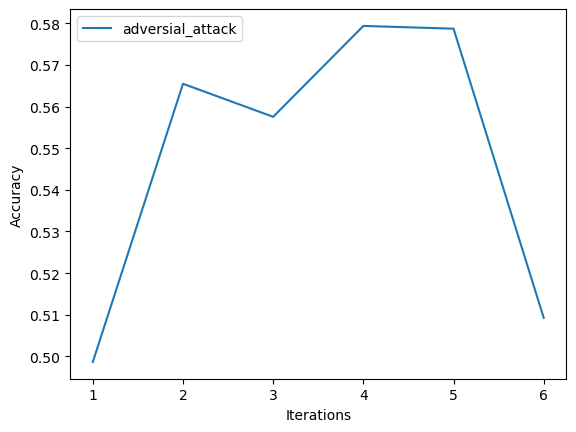

In [ ]:
for criterion in selection_criteria:
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      num_epochs=num_epoch)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
generate_plot(accuracy_scores_dict)

In [ ]:
accuracy_scores_dict

defaultdict(list,
            {'adversial_attack': [0.49867724867724866,
              0.5654761904761905,
              0.5575396825396826,
              0.5793650793650793,
              0.5787037037037037,
              0.5092592592592592]})